In [1]:
# Please run this notebook in python version >= '3.5'
# Also uploaded to a online Colab Notebook: https://colab.research.google.com/drive/17bQFZw8fokRn85iJc3hFRy-hJ45DvJ2S?usp=sharing

# All imports required to run the code

import abc
import collections
import functools
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
from typing import Tuple

%matplotlib inline

In [2]:
# All CONSTANTS used in the notebook

# URLs
# Image credits and rights belong to the owner of image.
# Images are just used for academic purposes. 
# https://apod.nasa.gov/apod/ap200921.html
# https://apod.nasa.gov/apod/ap200816.html
# https://apod.nasa.gov/apod/ap200904.html

# Set the path to the images
PATH = pathlib.Path('~/Downloads').expanduser()
PATH1 = PATH / 'OmegaSunSail_Sendra_960.jpg'
PATH2 = PATH / 'AndrewKlinger_wizard_sho_res25_sig1024.jpg'
PATH3 = PATH / 'CrabNebula_Hubble_960.jpg'

THRESHOLD1 = 50
THRESHOLD2 = None # Set Threshold
THRESHOLD3 = None # Set Threshold

# Other constants used
BITS_PER_PIXEL = 8
MIN_PIXEL_VALUE = 0
MAX_PIXEL_VALUE = 255

# 1 Binary Morphology

In [3]:
def rgb2gray(rgb):
    """Return grayscale form of a RGB image"""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(int)

def complement(img):
    """Return complement of a binary image"""
    return np.vectorize(lambda x: not x)(img).astype(int)

def valid(x, y, shape):
    """Returns True, if indices are within the bounds"""
    return (0 <= x < shape[0]) and (0 <= y < shape[1])

def clip(x, y, shape):
    return (min(max(x, 0), shape[0] - 1), min(max(y, 0), shape[1] - 1))

In [4]:
class Image():
    def __init__(self, path, threshold):
        self._path = path
        self._threshold = threshold
        self._original_image = mpimg.imread(self._path)
        self._grayscale_image = rgb2gray(self._original_image)
        self._black_white_image = (self._grayscale_image > threshold).astype(int)
    
    @property
    def original(self):
        return self._original_image
    
    @property
    def grayscale(self):
        return self._grayscale_image
    
    @property
    def black_white(self):
        return self._black_white_image

In [5]:
image = Image(PATH1, THRESHOLD1)
print(f'Original Image shape: {image.original.shape}')
print(f'Gray scale Image shape: {image.grayscale.shape}')

Original Image shape: (761, 960, 3)
Gray scale Image shape: (761, 960)


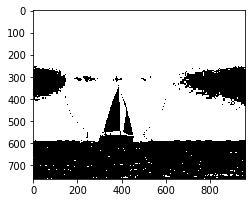

In [6]:
def plot_image(image, title='', show = True):
    plt.figure(figsize=(image.shape[0]/200, image.shape[1]/200))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    if show:
        plt.show()

plot_image(image.black_white, show=True)

In [7]:
class StructuringElement(abc.ABC):

    def __init__(self, count):
        self.count = count

    @property
    @abc.abstractmethod
    def relative_coordinates(self):
        pass

class Cross(StructuringElement):

    @property
    def relative_coordinates(self):
        mid = self.count//2
        return ({(0, i) for i in range(-mid, mid + 1)} | {(i, 0) for i in range(-mid, mid + 1)})

class Square(StructuringElement):

    @property
    def relative_coordinates(self):
        mid = self.count//2
        rel_coords = set()
        for i in range(-mid, mid + 1):
            for j in range(-mid, mid + 1):
                rel_coords.add((i,j))
        return rel_coords

In [8]:
class BinaryFilter(abc.ABC):

    @abc.abstractmethod
    def operation(self, windowed_set):
        pass

    def get_image_values(self, coordinates, img, x, y):
        return [img[clip(i, j, img.shape)] for (i, j) in map(lambda point: (x + point[0], y + point[1]), coordinates)]
    
    def run(self, coordinates, img):
        res = np.zeros(img.shape)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                res[i][j] = self.operation(self.get_image_values(coordinates, img, i, j))
        return res

class Dilation(BinaryFilter):
    def operation(self, windowed_set):
        return int(any(windowed_set))

class Erosion(BinaryFilter):
    def operation(self, windowed_set):
        return int(all(windowed_set))

class Median(BinaryFilter):
    def operation(self, windowed_set):
        return (lambda x: x[len(x)//2])(sorted(windowed_set))

In [9]:
def check_complement_duality(image, filter1, filter2, windowed_set):
    filter1_img = filter1.run(windowed_set.relative_coordinates, image)
    filter2_img = filter2.run(windowed_set.relative_coordinates, complement(image))
    assert np.array_equal(filter1_img, complement(filter2_img))
    print(f'Hence {type(filter1).__name__} is the dual of {type(filter2).__name__} with respect to complementation.')

Continuing from the previous assignment, write code to verify that:
- DILATE is the dual of ERODE with respect to complementation.
- ERODE is the dual of DILATE with respect to complementation.
- MEDIAN is its own dual with respect to complementation.

Verify this by showing that the difference between the images from the direct and complement paths is indeed zero.

In [10]:
for w in [Cross(5)]:
    check_complement_duality(image.black_white, Dilation(), Erosion(), w)
    check_complement_duality(image.black_white, Erosion(), Dilation(), w)
    check_complement_duality(image.black_white, Median(), Median(), w)

Hence Dilation is the dual of Erosion with respect to complementation.
Hence Erosion is the dual of Dilation with respect to complementation.
Hence Median is the dual of Median with respect to complementation.


In [11]:
def plot_histogram(image, title='', bins=range(256), show=False):
    plt.figure()
    plt.hist(image.flatten(), bins=bins)
    plt.title(title)
    if show:
        plt.show()

# 2 Gray scale operations

## 2.1.

Perform simple linear point operations for the following cases:  
(a) J = P.I.  
(b) J = I + L.  
In each case, verify that the histogram of J is related to the histogram of I according to the relation discussed in class.

In [12]:
def linear_point_transform(image, scale=1, offset=0):
    res = np.copy(image)
    return np.clip(res * scale + offset, MIN_PIXEL_VALUE, MAX_PIXEL_VALUE).astype(int)

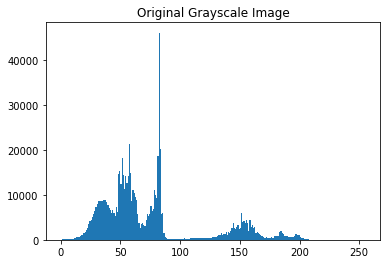

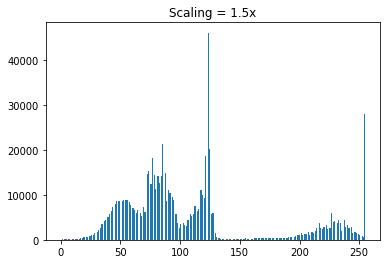

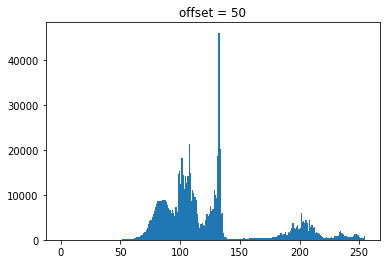

In [13]:
plot_histogram(image.grayscale, title='Original Grayscale Image')
scaled_image = linear_point_transform(image.grayscale, scale=1.5)
plot_histogram(scaled_image, title='Scaling = 1.5x')
offset_image = linear_point_transform(image.grayscale, offset=50)
plot_histogram(offset_image, title='offset = 50', show=True)

## 2.2 Full scale contrast stretch (FSCS).

Verify your result by printing the min and max pixel values before and after applying FSCS. Also, plot the histogram of the image before and after applying FSCS.

In [14]:
def get_fscs_scale_offset(image):
    max_val, min_val = np.max(image), np.min(image)
    scale = MAX_PIXEL_VALUE / (max_val - min_val)
    offset = - min_val * MAX_PIXEL_VALUE / (max_val - min_val)
    return (scale, offset)

In [15]:
max_val, min_val = np.max(image.grayscale), np.min(image.grayscale)
print(f'Original Image:\nMax Value = {max_val}, Min Value = {min_val}\n')

scale, offset = get_fscs_scale_offset(image.grayscale)

fscs_image = linear_point_transform(image.grayscale, scale=scale, offset=offset)

max_val, min_val = np.max(fscs_image), np.min(fscs_image)
print(f'FSCS Image:\nMax Value = {max_val}, Min Value = {min_val}')

Original Image:
Max Value = 231, Min Value = 0

FSCS Image:
Max Value = 255, Min Value = 0


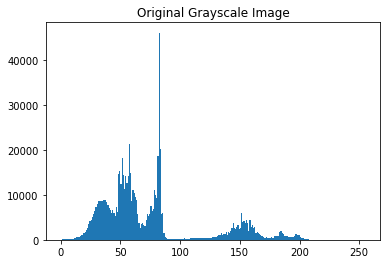

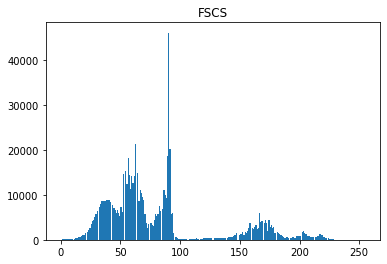

In [16]:
plot_histogram(image.grayscale, title='Original Grayscale Image')
plot_histogram(fscs_image, title='FSCS', show=True) 

## 2.3 Log magnitude compression (always followed by FSCS).
Plot the histogram of the image before and after applying log magnitude compression.

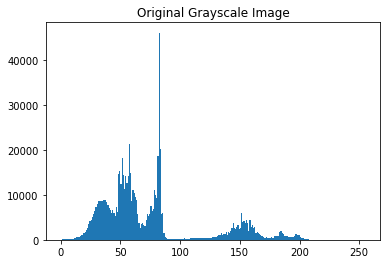

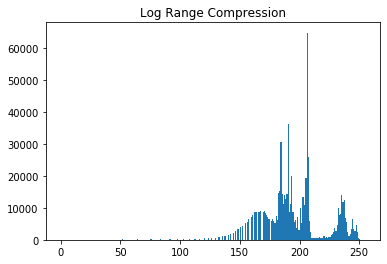

In [17]:
log_compression_image = np.log(image.grayscale + 1)
scale, offset = get_fscs_scale_offset(log_compression_image)

fscs_log_image = linear_point_transform(log_compression_image, scale=scale, offset=offset)

plot_histogram(image.grayscale, title='Original Grayscale Image')
plot_histogram(fscs_log_image, title='Log Range Compression', show=True) 


## 2.4 Histogram flattening.
Plot the histogram of the image before and after applying histogram flattening.

In [18]:
def histogram_flattening(image):
    histogram = np.histogram(image.flatten(), bins=range(256))[0]
    cumilative_sum = np.cumsum(histogram) / (image.shape[0] * image.shape[1])
    J = np.vectorize(lambda x: cumilative_sum[x])(image)
    scale, offset = get_fscs_scale_offset(J)
    return linear_point_transform(J, scale=scale, offset=offset)

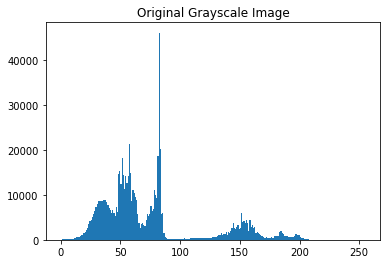

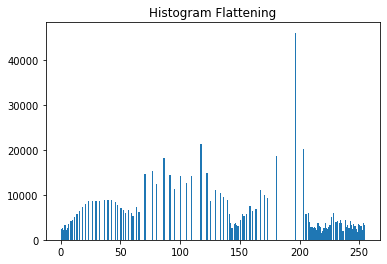

In [19]:
plot_histogram(image.grayscale, title='Original Grayscale Image')
histogram_flattening_image = histogram_flattening(image.grayscale)
plot_histogram(histogram_flattening_image, title='Histogram Flattening', show=True)

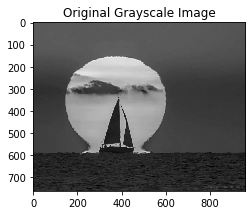

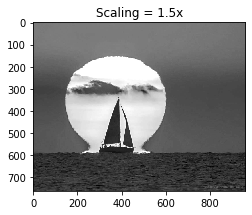

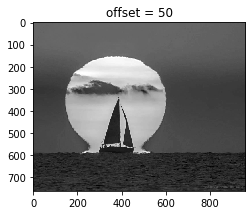

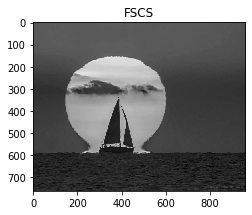

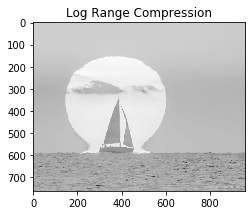

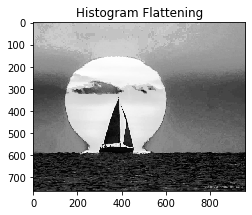

In [20]:
plot_image(image.grayscale, title='Original Grayscale Image')
plot_image(scaled_image, title='Scaling = 1.5x')
plot_image(offset_image, title='offset = 50')
plot_image(fscs_image, title='FSCS') 
plot_image(fscs_log_image, title='Log Range Compression') 
plot_image(histogram_flattening_image, title='Histogram Flattening', show=True)

- Histogram Flatten allows us to experience a lot of shades in one image. Hence enhancing the experience
- Offset and scaling change brightness of the image.
- Log Compression increases intensity of darker regions
- FCFS does not have significant changes in this case as the range of intensity is quite spread out.

# 3. Zooming
Write a program to zoom an image by 1.5 times along each axis using the following techniques discussed in class:

## 3.1 Nearest neighbor.

In [21]:
def nn_zoom(image, scale):
    res_w, res_h = round(image.shape[0]*scale[0]), round(image.shape[1]*scale[1])
    res = np.zeros((res_w, res_h))
    for i in range(res_w):
        for j in range(res_h):
            res[i][j] = image[clip(round(i/scale[0]), round(j/scale[1]), image.shape)]
    return res


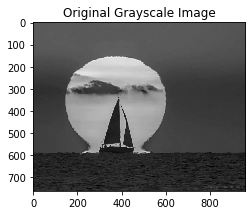

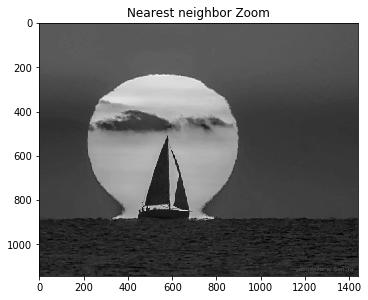

In [22]:
plot_image(image.grayscale, title='Original Grayscale Image')
scale = (1.5, 1.5)
plot_image(nn_zoom(image.grayscale, scale), title='Nearest neighbor Zoom', show=True)


## 3.2. Bilinear interpolation.

In [23]:
def get_nn(location, shape, scale):
    i, j = location
    top_left = clip(int(i/scale[0]), int(j/scale[1]), shape)
    top_right = clip(top_left[0], top_left[1]+1, shape)
    bottom_left = clip(top_left[0]+1, top_left[1], shape)
    bottom_right = clip(top_left[0]+1, top_left[1]+1, shape)
    return np.array([top_left, top_right, bottom_left, bottom_right])

def bilinear_zoom(image, scale):
    res_w, res_h = round(image.shape[0]*scale[0]), round(image.shape[1]*scale[1])
    res = np.zeros((res_w, res_h))
    for i in range(res_w):
        for j in range(res_h):
            nearest_neighbours = get_nn((i, j), image.shape, scale)
            RHS = np.array([[image[p1][p2] for (p1, p2) in nearest_neighbours]]).T
            matrix = np.array([[1, p1*scale[0], p2*scale[0], p1*p2*scale[0]*scale[1]] for (p1, p2) in nearest_neighbours])
            a, b, c, d = np.linalg.pinv(matrix) @ RHS
            res[i][j] = a + b*i + c*j + d*i*j
    return res

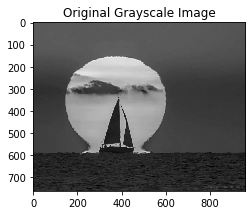

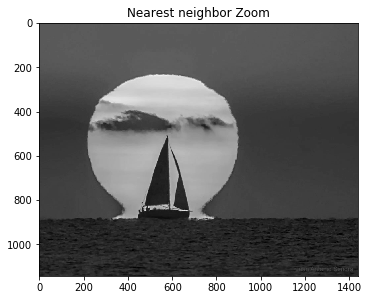

In [24]:
plot_image(image.grayscale, title='Original Grayscale Image')
scale = (1.5, 1.5)
plot_image(bilinear_zoom(image.grayscale, scale), title='Nearest neighbor Zoom', show=True)

Q Test your program using three of your favorite images from the above set. Comment on the quality of the two techniques and compare their computational complexity.

Ans:

Time complexity of both the approach is `k * O(size of final image)` because
- At each pixel we do some constant `k` operations.
- We fill the zoomed image by iterating over each pixels.

However, the constant k is:
 - Very low in case of Nearest Neighbours (Just some divisions and round-offs)
 - Very high in case of Bilinear Interpolation method. (Inverting 4 x 4 matrix almost `sizeOf(Final image)` number of times)